In [1]:
import anndata as ad
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sys, os
from collections import defaultdict

#sys.path.append('.')

from sklearn.cluster import KMeans

import geneinfo.information as gi

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# scale down size of default plots
sns.set_context("paper")
import matplotlib as mpl
scale = 0.8
d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
d['figure.figsize'] = [5.4, 3.5]
mpl.rcParams.update(d)

# high-res plots
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')

#from matplotlib_venn import venn2, venn3

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
            [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)

from math import sqrt
from itertools import zip_longest

def list_genes(words, ncols=None):
    n = len(words)
    col_width = max(map(len, words)) + 1
    if ncols is None:
        ncols = max(100//col_width, 1+sqrt(n/col_width))
    nrows = int(n/ncols) + 1
    rows = []
    for r in range(0, n, nrows):
        rows.append(words[r:r+nrows])
    for row in list(zip_longest(*rows, fillvalue='')):
        line = []
        for gene in row:
            line.append(gene.ljust(col_width))
        print(''.join(line))
        

In [2]:
# %env http_proxy=http://proxy-default:3128
# %env https_proxy=http://proxy-default:3128

In [3]:
import expression_plots as ep
# import importlib
# importlib.reload(ep)
# ep.load_data("../data/xy_proj/preproc_8_starsolo_multimap_simpl_soupx.h5ad")

ep.load_data("../data/xy_proj/CELL_preproc_8_starsolo_multimap.h5ad")
# ep.adata.X = ep.adata.layers["soupX_counts"].copy()
# sc.pp.normalize_total(ep.adata)
# sc.pp.log1p(ep.adata)
# ep.adata.layers["norm_log"] = ep.adata.X.copy()

# .obs["SPECIES"] == "Human" for nuclei data and 
# .obs["SPECIES"] == "Human_cell" for cell data


#ep.adata = ep.adata[(ep.adata.obs.SPECIES == "Human")]
ep.adata = ep.adata[ep.adata.obs.SPECIES == "Human_cell", ep.adata.var.chromosome == 'X']


In [4]:
ep.adata

View of AnnData object with n_obs × n_vars = 15712 × 552
    obs: 'DATASET', 'total_counts', 'n_genes_by_counts', 'percent_mito', 'prop_unspl', 'prop_spl', 'doublet_scores', 'predicted_doublets', 'SPECIES', '_scvi_batch', '_scvi_labels', 'leiden', 'CB_exp', 'cluster', 'clst_groups', 'clst_groups_class', 'cell_class', 'clst_groups_sep', 'mean_spg_exp', 'mean_spt_exp_1', 'mean_spt_exp_2', 'Pseudotime_scaled', 'cell_diff', 'percent.X', 'percent.Y', 'percent.X_unspl', 'percent.Y_unspl', 'enrich_rate', 'enrich_rate_scaled'
    var: 'chromosome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'DATASET_colors', 'SPECIES_colors', '_scvi_manager_uuid', '_scvi_uuid', 'clst_groups_colors', 'cluster_colors', 'cluster_sizes', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'paga', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'norm_sct', 'raw_counts', 'soupX_counts', 'spliced', 'unspl_norm', 'unspliced'
  

Distribution of cell counts across pseudo-time:

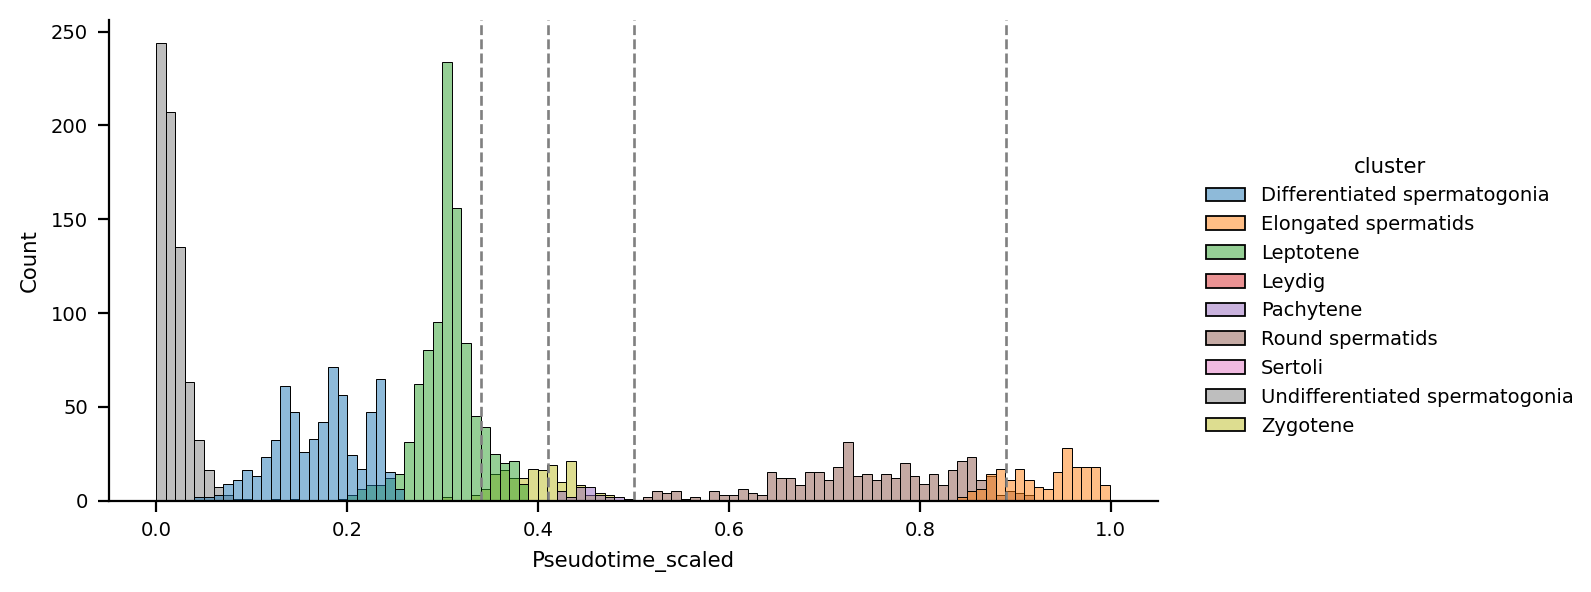

In [5]:
df = sc.get.obs_df(ep.adata, keys=['cluster', 'Pseudotime_scaled'])
sns.displot(df, x='Pseudotime_scaled', hue='cluster', bins=100, height=3, aspect=2) ;
lines = [0.34, 0.41, 0.5, 0.89]
[plt.axvline(x, color='grey', linestyle='dashed') for x in lines] ;

In [6]:
from geneinfo.utils import GeneListCollection
sheet = GeneListCollection(google_sheet='1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk')
sheet

| label | description |
|:---|:---|
| **all_npx** | all NPX genes |
| **neuron_genome_proteome** | Neuron proteome (whole genome) |
| **neuron_npx_proteome** | NPX neuron proteome |
| **matos_neuron** | Matos neuron genes |
| **matos_common** | Matos neuron genes expressed in spermatids |
| **hpa_brain_prot** | Brain genes form Human protein atlas |
| **meritxell_spermatid_expr** |  |
| **mult_copy** | Multi copy genes |
| **primate_ampl_multi** | Ampliconic or multicopy in some primates |
| **gametologs** | Gametologs in some primates |
| **old_cDEG** | Old cDEG |
| **cDEG** | The rerun cDEGs |
| **cDEG_alt** |  |
| **Old nDEG** | old nDEG |
| **nDEG** | nDEG |
| **hybridDEG** |  |
| **chromatin_genes** | chromatin genes according to biology GPT |
| **circRNA** | circRNA |
| **xi** | Subject to somatic X inactivation (XI) |
| **xi_escape** | Escaping somatic X inactivation (XI) |
| **xi_uncertain** | cDEG and Xi escape |
| **xi_any_evidence** | allDEG and Xi escape |
| **expr_mod_xi_copynr_fibrobl** | Xi escapers in either ECH,  hama or hum-nean |
| **expr_mod_xi_copynr_lcl** | Xi escapers in ECH or hum-nean |
| **expr_mod_xi_copynr** | Xi escapers  in hama or hum-nean |
| **pure_hama** | Xi escapers  in hum-nean |
| **hum_nean_admix** | Xi escapers  in ECH90 |
| **ari_relate_EUR** | Xi escapers  in hama |
| **ari_relate_ASIA** | Xi escaping (primate)  gametologs |
| **ari_relate_AFR** | Xi escaping (primate)  gametologs in hum-nean |
| **ari_nonPUR** | Xi escaping (primate)  gametologs in hama |
| **ari_relate_PUR** | Xi escape in ari_nonPUR |
| **ari_all** | Xi escape in accel_reg_simiiformes_br |
| **candidates** | X genes uncertain XI status |
| **ech75_regions** | Union of certain  and uncertain  XI status |
| **ech90_regions** | Expression  modulated by Xi copy number (Fibroblast) |
| **accel_reg_simiiformes_br** | Expression  modulated by Xi copy number (LCL) |
| **my_primate_codeml** | Expression  modulated by Xi copy number (Fibroblast or LCL) |
| **reg_sa_pheno** | Genes in 95% pure hamadryas regions in Gog |
| **sfari_all_conf** | Human-Neanderthal introgression |
| **intel_seiz_lang** |  |
| **intelect_disabil** |  |
| **Xbrain** |  |

In [7]:
# def read_google_sheet():
#     SHEET_ID = '1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk'
#     SHEET_NAME = 'Sheet1'
#     url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
#     df = pd.read_csv(url, header=1)
#     return df.loc[:, [not x.startswith('Unnamed') for x in df.columns]]
    
# def gene_list_names():
#     df = read_google_sheet()
#     return sorted(df.columns.tolist())

# def gene_list(name):
#     df = read_google_sheet()
#     sr = df[name]
#     return sr[~sr.isnull()]
    
# gene_list_names()

In [8]:
set1 = [
 'SCML1',
 'CFAP47',
    
 'EIF1AX',
 'DYNLT3',
 'SYTL5',
 'DDX3X',
 'PRICKLE3',
 'SYP',
 'IQSEC2',

 'mc_ampl_SPANXN5',
 'HUWE1',
 'PHF8',
 'EDA',
 'DIAPH2',    
 'SRPX2',
 'RBM41',
 'VSIG1',
 'RTL4',
 'HTR2C',
 'UPF3B',
 'OCRL',
 'EMD',
]

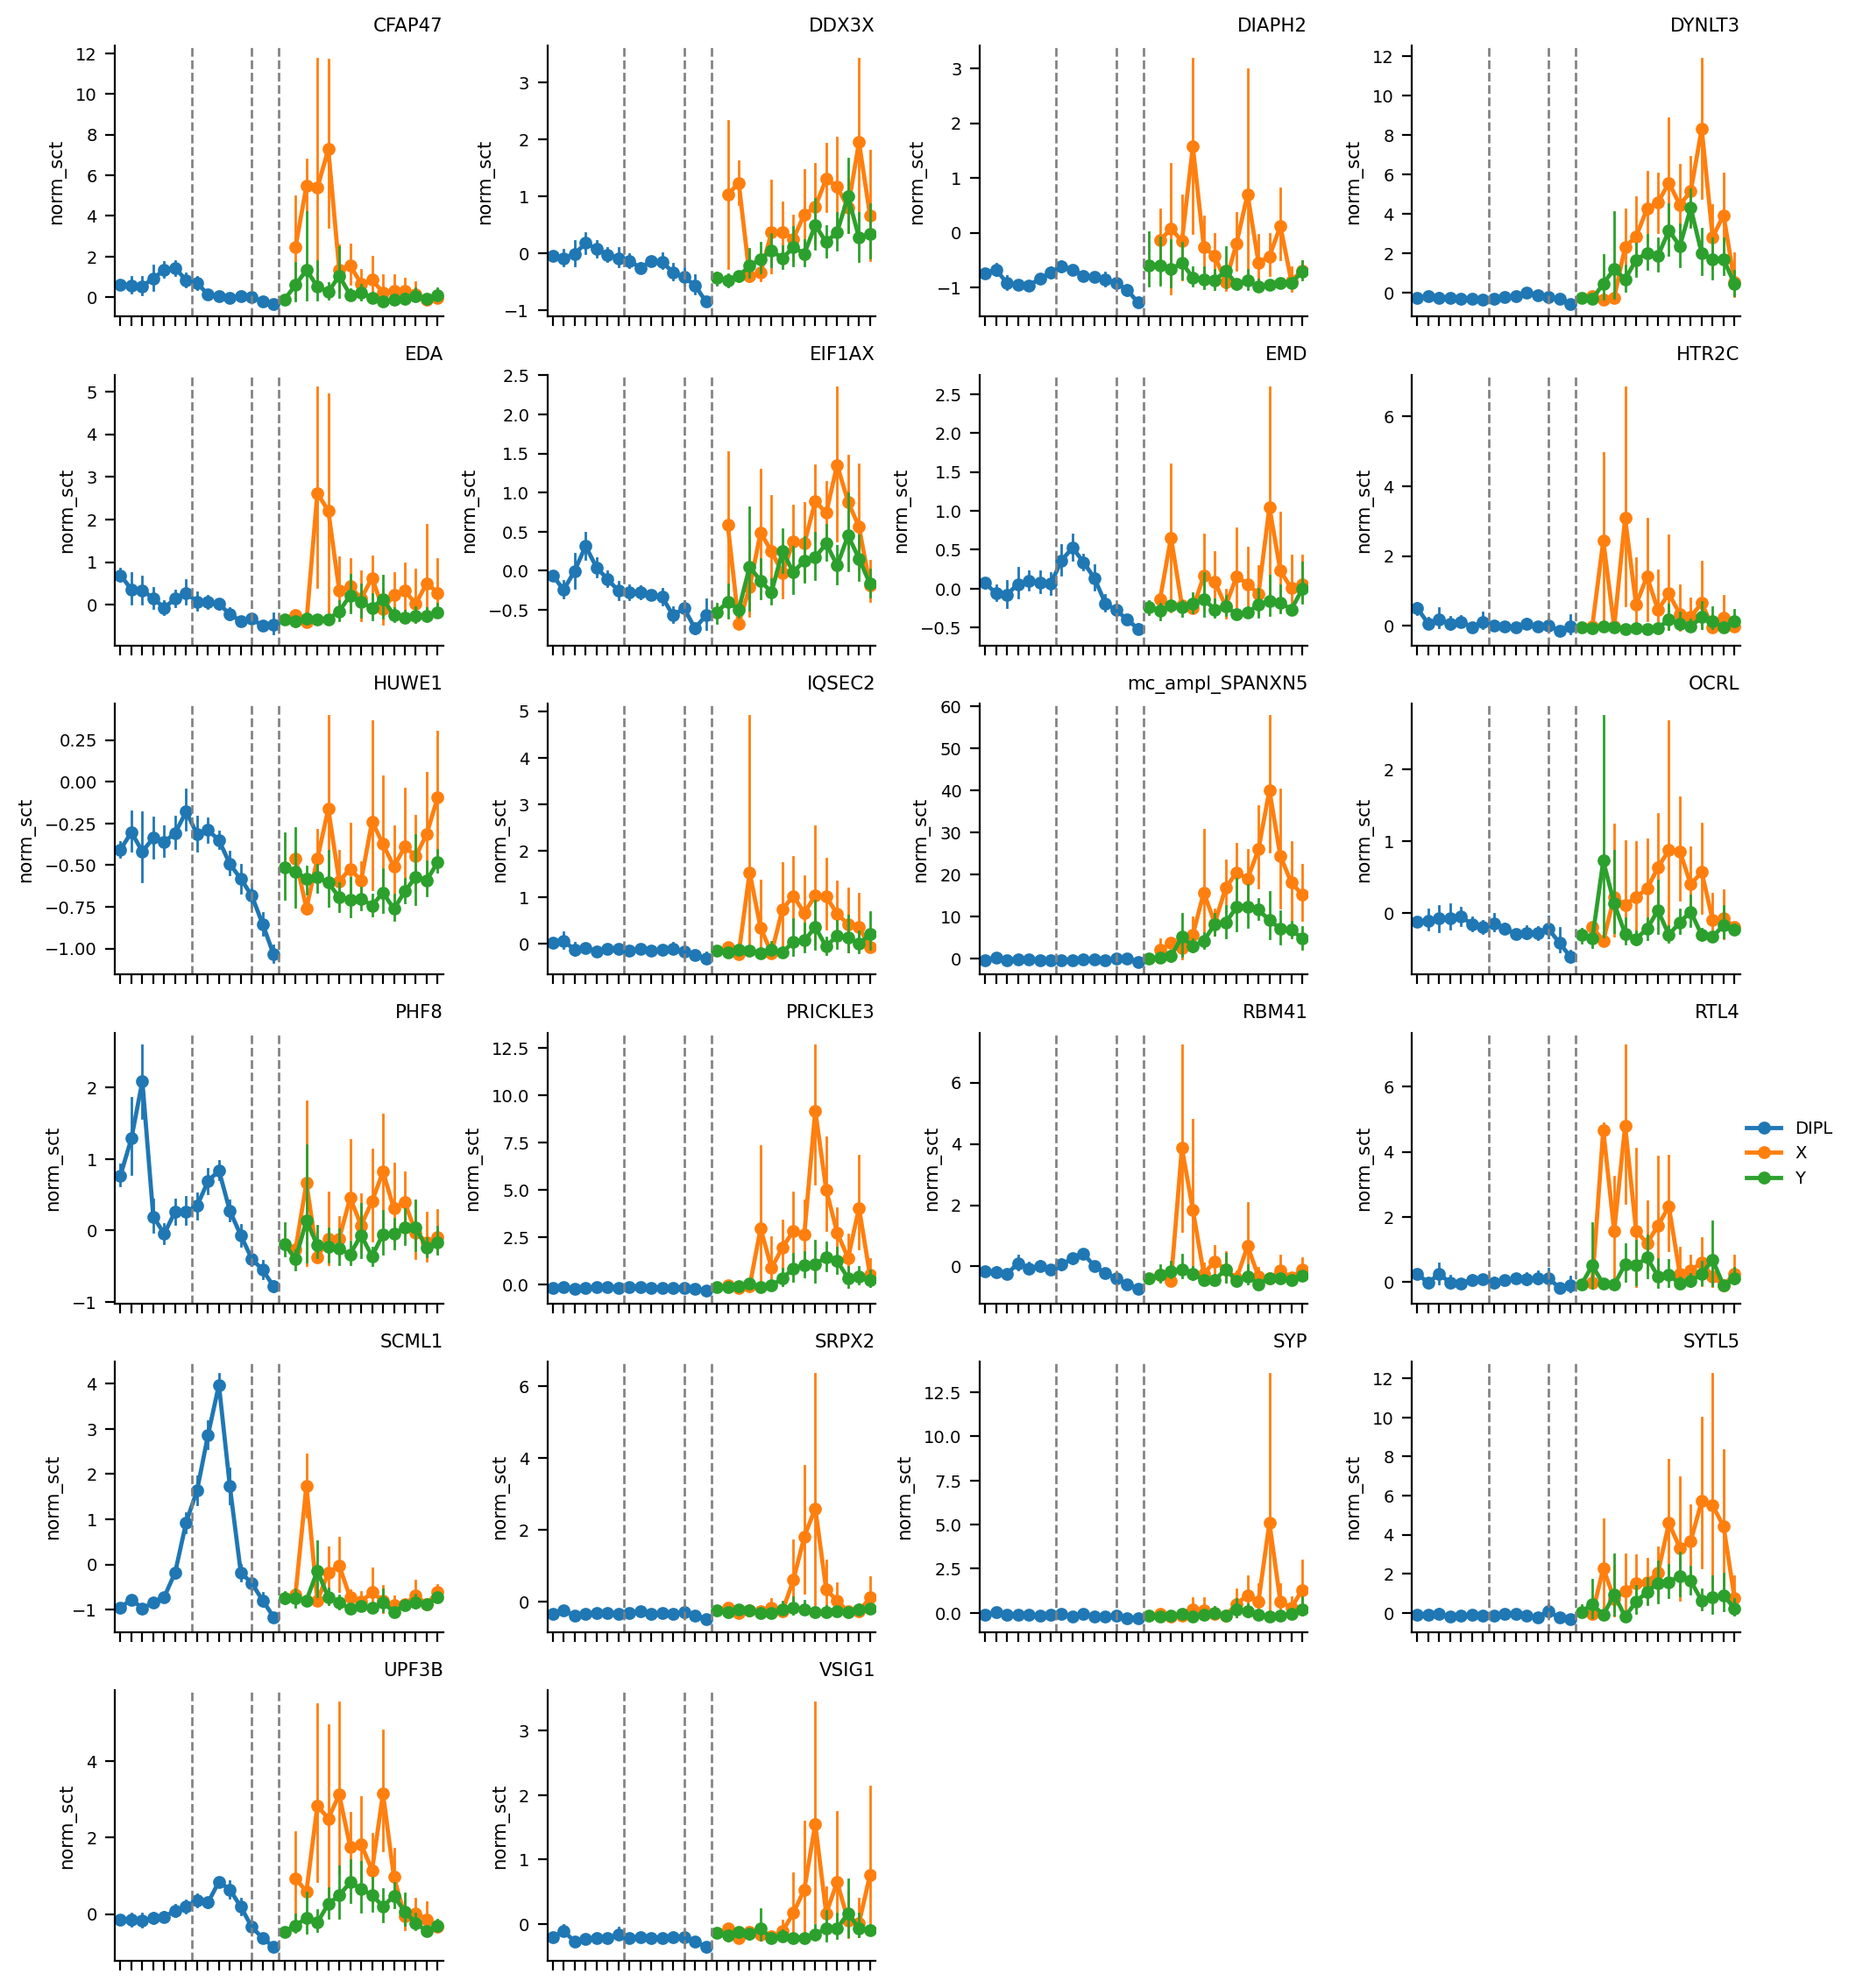

In [9]:
ep.facet_plot(sheet.get('cDEG'), ep.split_trajectory, 'norm_sct', sharey=False, errorbar=True, ncols=4)

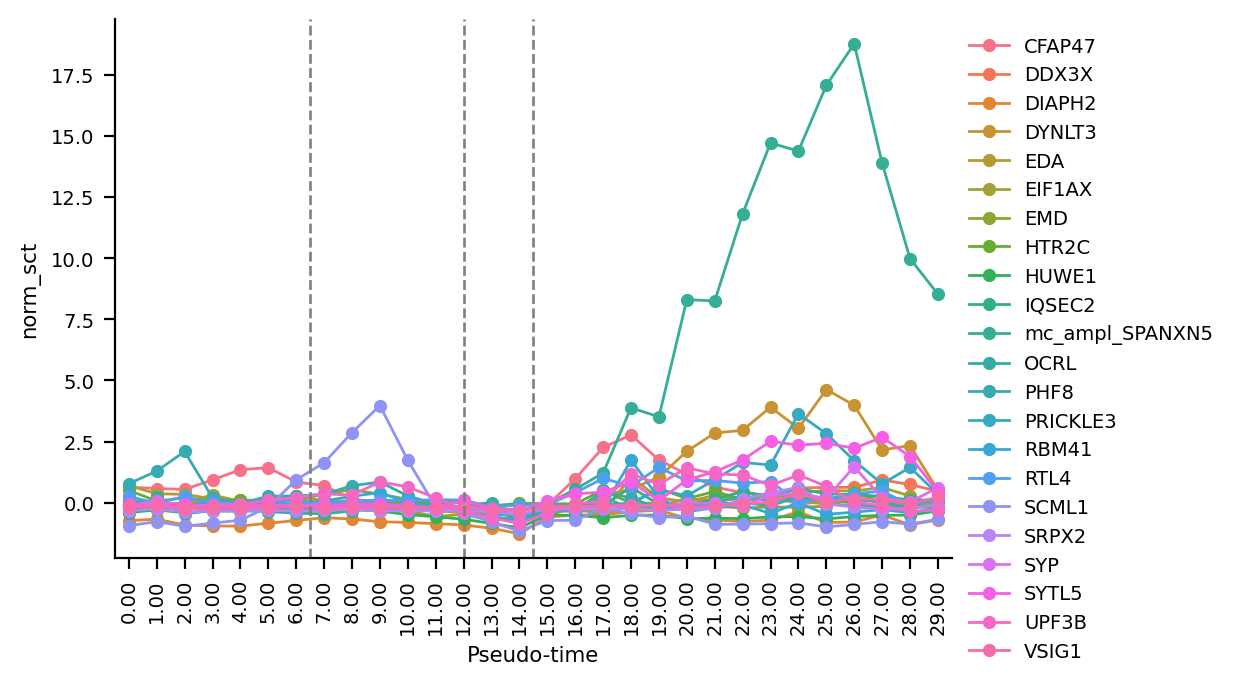

In [10]:
ep.trajectory(sheet.get('cDEG'), 'norm_sct') ;

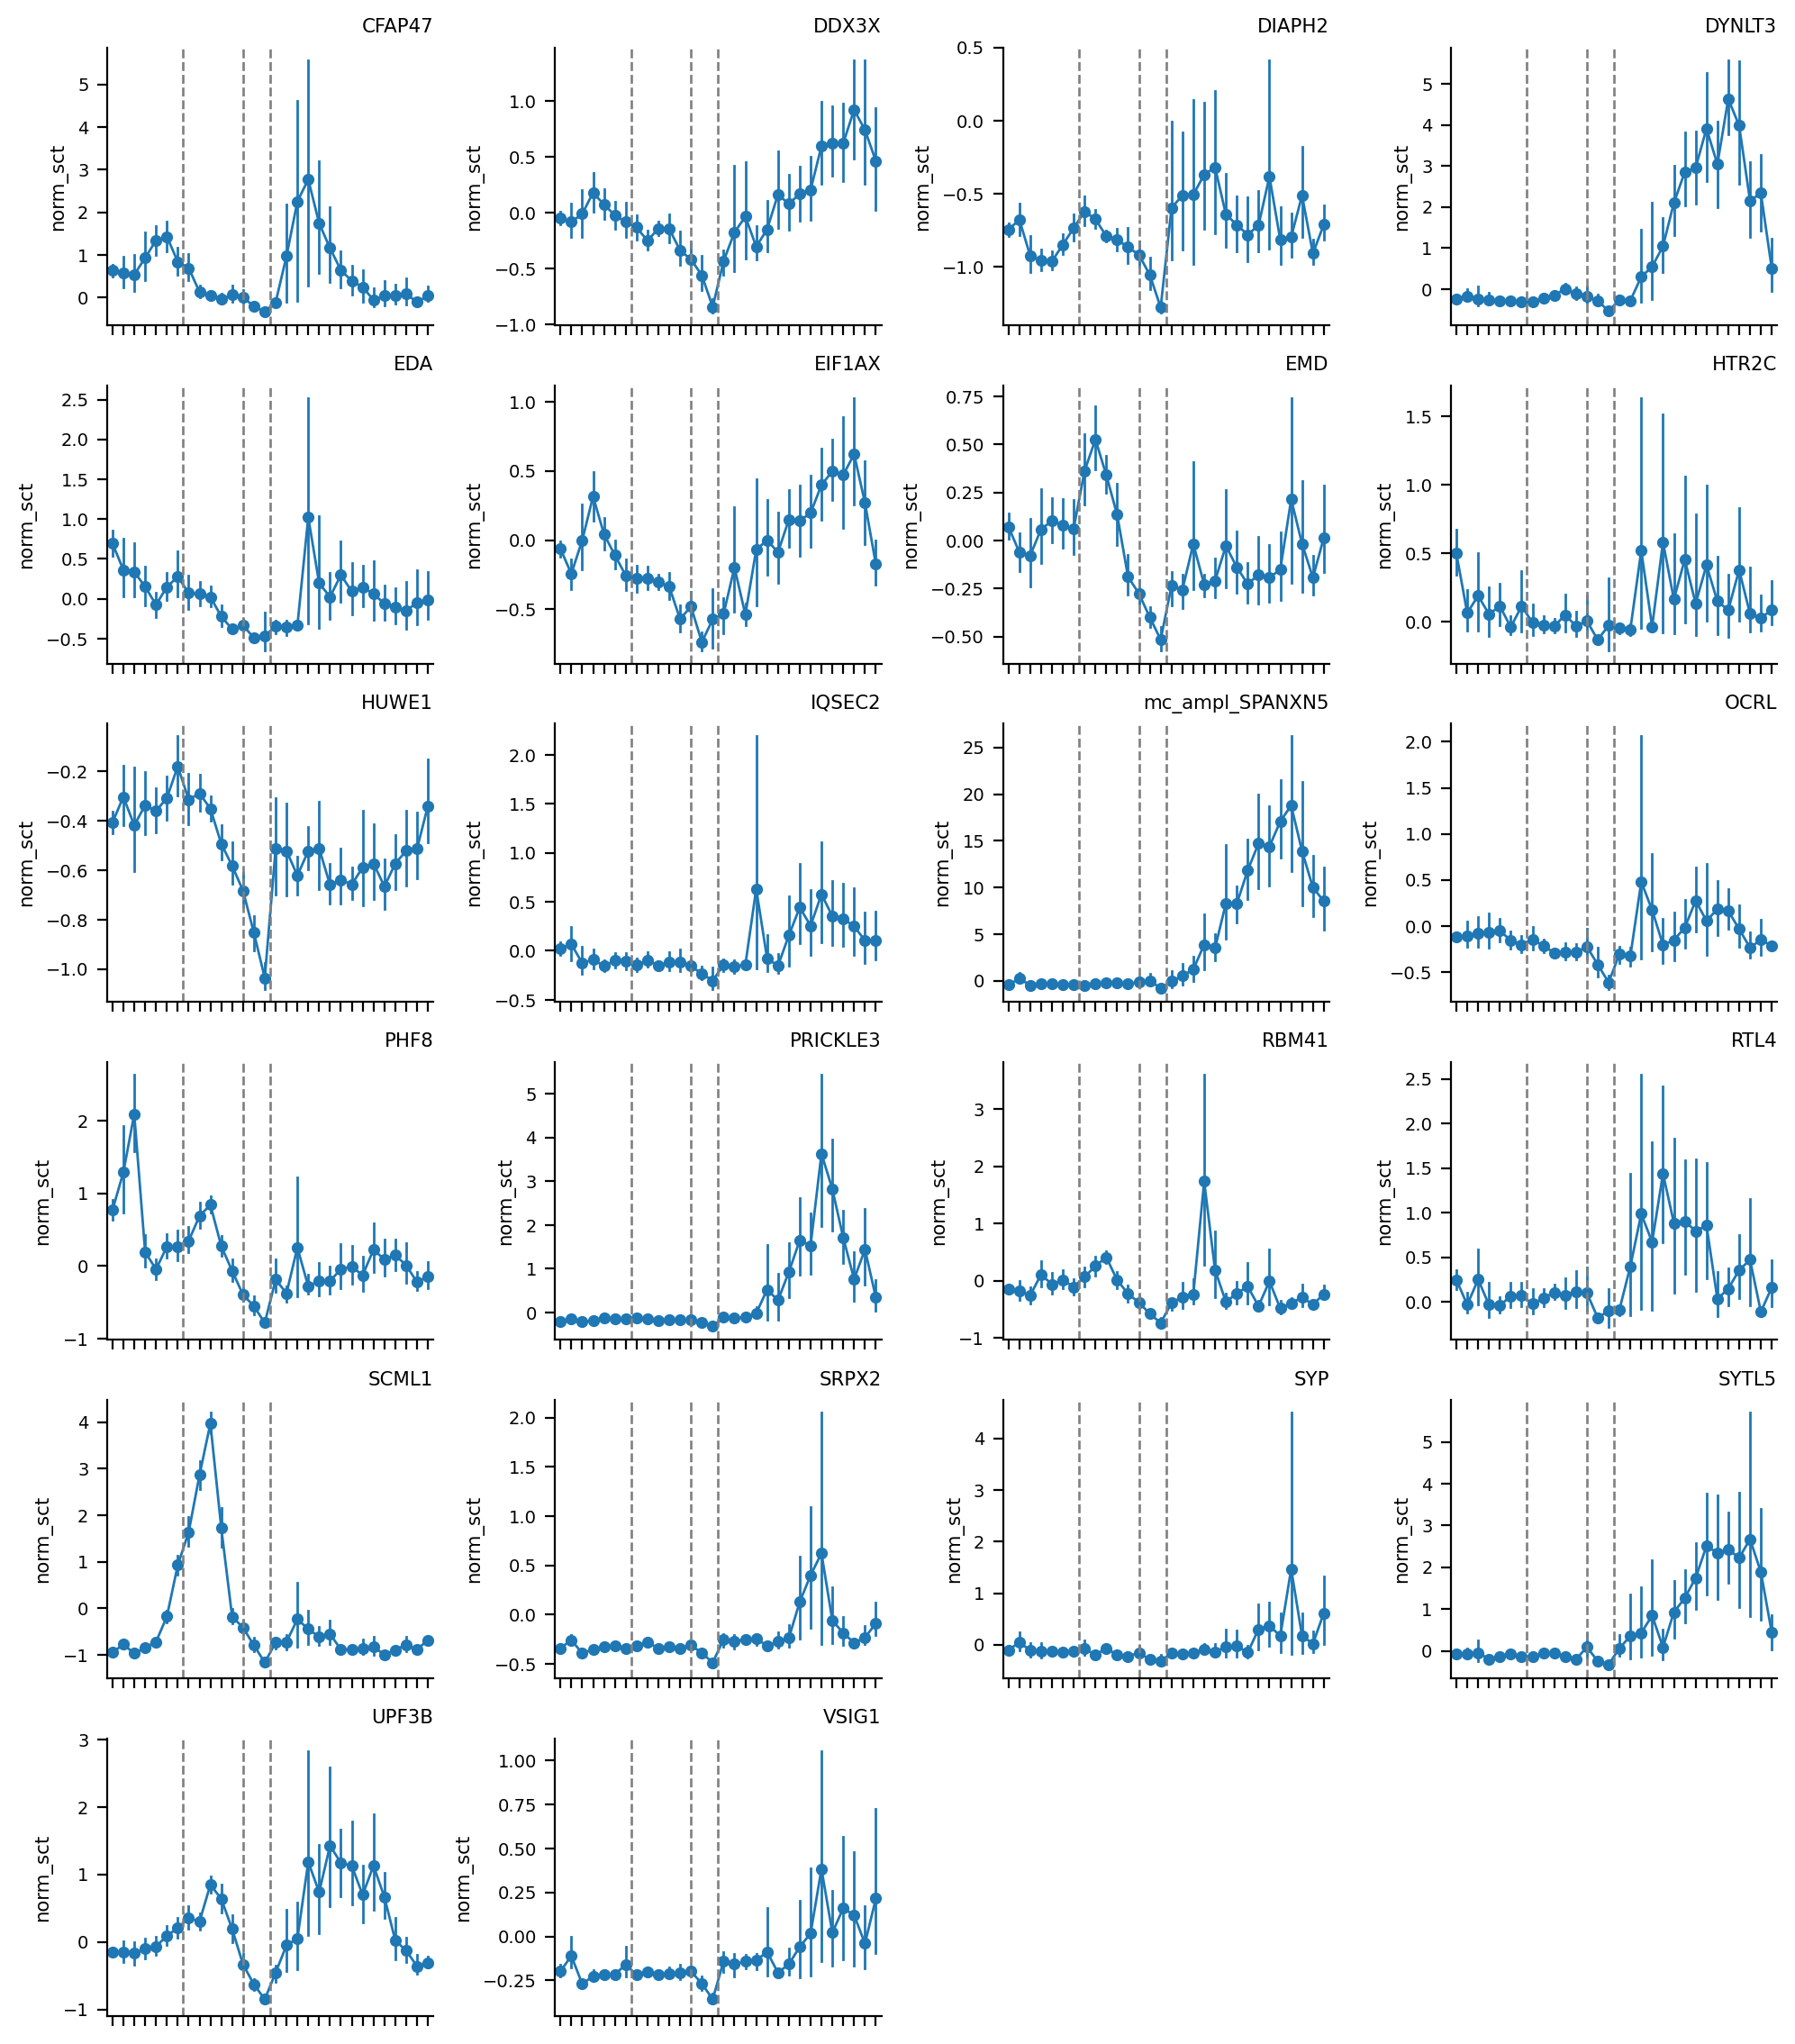

In [11]:
ep.facet_plot(sheet.get('cDEG'), ep.trajectory, 'norm_sct', sharey=False, errorbar=True, ncols=4)

In [12]:
# df = ep.adata[ep.adata.obs.SPECIES == "Human"].to_df(layer='norm_sct')
# df = ep.adata[(ep.adata.obs.SPECIES == "Human") & (ep.adata.obs.Pseudotime_scaled > 0.5)].to_df(layer='norm_sct')
df = ep.adata[ep.adata.obs.Pseudotime_scaled > 0.5].to_df(layer='norm_sct')
df['ptime'] = pd.cut(ep.adata.obs.Pseudotime_scaled, include_lowest=True, bins=30)
ptime_bins = df['ptime'].unique().sort_values()
ptime_bins = ptime_bins[~ptime_bins.isnull()]
means_fine_df_all = df.groupby('ptime').mean()
means_fine_df_all.columns.name = 'gene'
means_fine_df_all = means_fine_df_all.transpose()
means_fine_df_all = means_fine_df_all[ptime_bins]

# only chrX
means_fine_df = means_fine_df_all.loc[ep.adata.var.chromosome == 'X']
means_fine_df.head()

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_53088/639468700.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_fine_df_all = df.groupby('ptime').mean()


ptime,"(0.5, 0.533]","(0.533, 0.566]","(0.566, 0.6]","(0.6, 0.633]","(0.633, 0.666]","(0.666, 0.699]","(0.699, 0.733]","(0.733, 0.766]","(0.766, 0.799]","(0.799, 0.833]","(0.833, 0.866]","(0.866, 0.899]","(0.899, 0.933]","(0.933, 0.966]","(0.966, 0.999]"
gene,,,,,,,,,,,,,,,
GYG2,-0.042098,-0.054876,-0.034658,-0.036454,-0.076823,-0.076040,-0.084007,0.019663,-0.017971,-0.088350,0.005949,-0.069784,-0.058722,-0.056151,-0.013729
MXRA5,-0.018554,-0.025011,-0.010371,-0.015871,-0.030468,0.295876,0.431500,0.300871,0.071361,-0.033366,-0.044535,-0.024393,-0.019173,-0.017819,-0.003941
PUDP,-0.117598,-0.302116,-0.277936,-0.273423,-0.254617,-0.365321,-0.340281,-0.360356,-0.375457,-0.388593,-0.416792,-0.338970,-0.320934,-0.240708,-0.136183
PNPLA4,-0.144925,-0.161147,-0.146323,-0.138263,-0.115004,-0.019218,-0.224271,-0.123541,-0.219987,-0.228769,-0.262250,-0.115995,-0.138356,-0.172467,-0.079661
ANOS1,-0.284120,0.045663,-0.281897,-0.277307,-0.363920,-0.367769,-0.295296,-0.389769,-0.310458,-0.390626,-0.418130,-0.353758,-0.323922,-0.271398,-0.101743


In [13]:

# gene list
means_fine_df = means_fine_df.loc[sheet.get('cDEG')]

In [18]:
n_clusters = 12
membership_labels = list(range(n_clusters))
ptime_columns = means_fine_df.columns
#ptime_columns = means_fine_df.columns[[x > pd.Interval(0.4, 1, closed='right') for x in means_fine_df.columns]]
X = means_fine_df[ptime_columns].values

kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=0).fit(X)
df = pd.DataFrame().from_records(kmeans.cluster_centers_, columns=ptime_columns)
df.index.name = 'membership'
df.columns.name = 'ptime'
plot_df = df.stack().to_frame('expression').reset_index()
#plot_df.tail()

python(17717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [19]:
memberships = kmeans.predict(X)
means_fine_df_with_memberships = means_fine_df.copy()
means_fine_df_with_memberships.columns = means_fine_df_with_memberships.columns.tolist() # remvoe categoriesfrom column index
means_fine_df_with_memberships['membership'] = memberships
plot_df = means_fine_df_with_memberships.reset_index().melt(id_vars=['gene', 'membership'], var_name='ptime', value_name='expression')
#plot_df

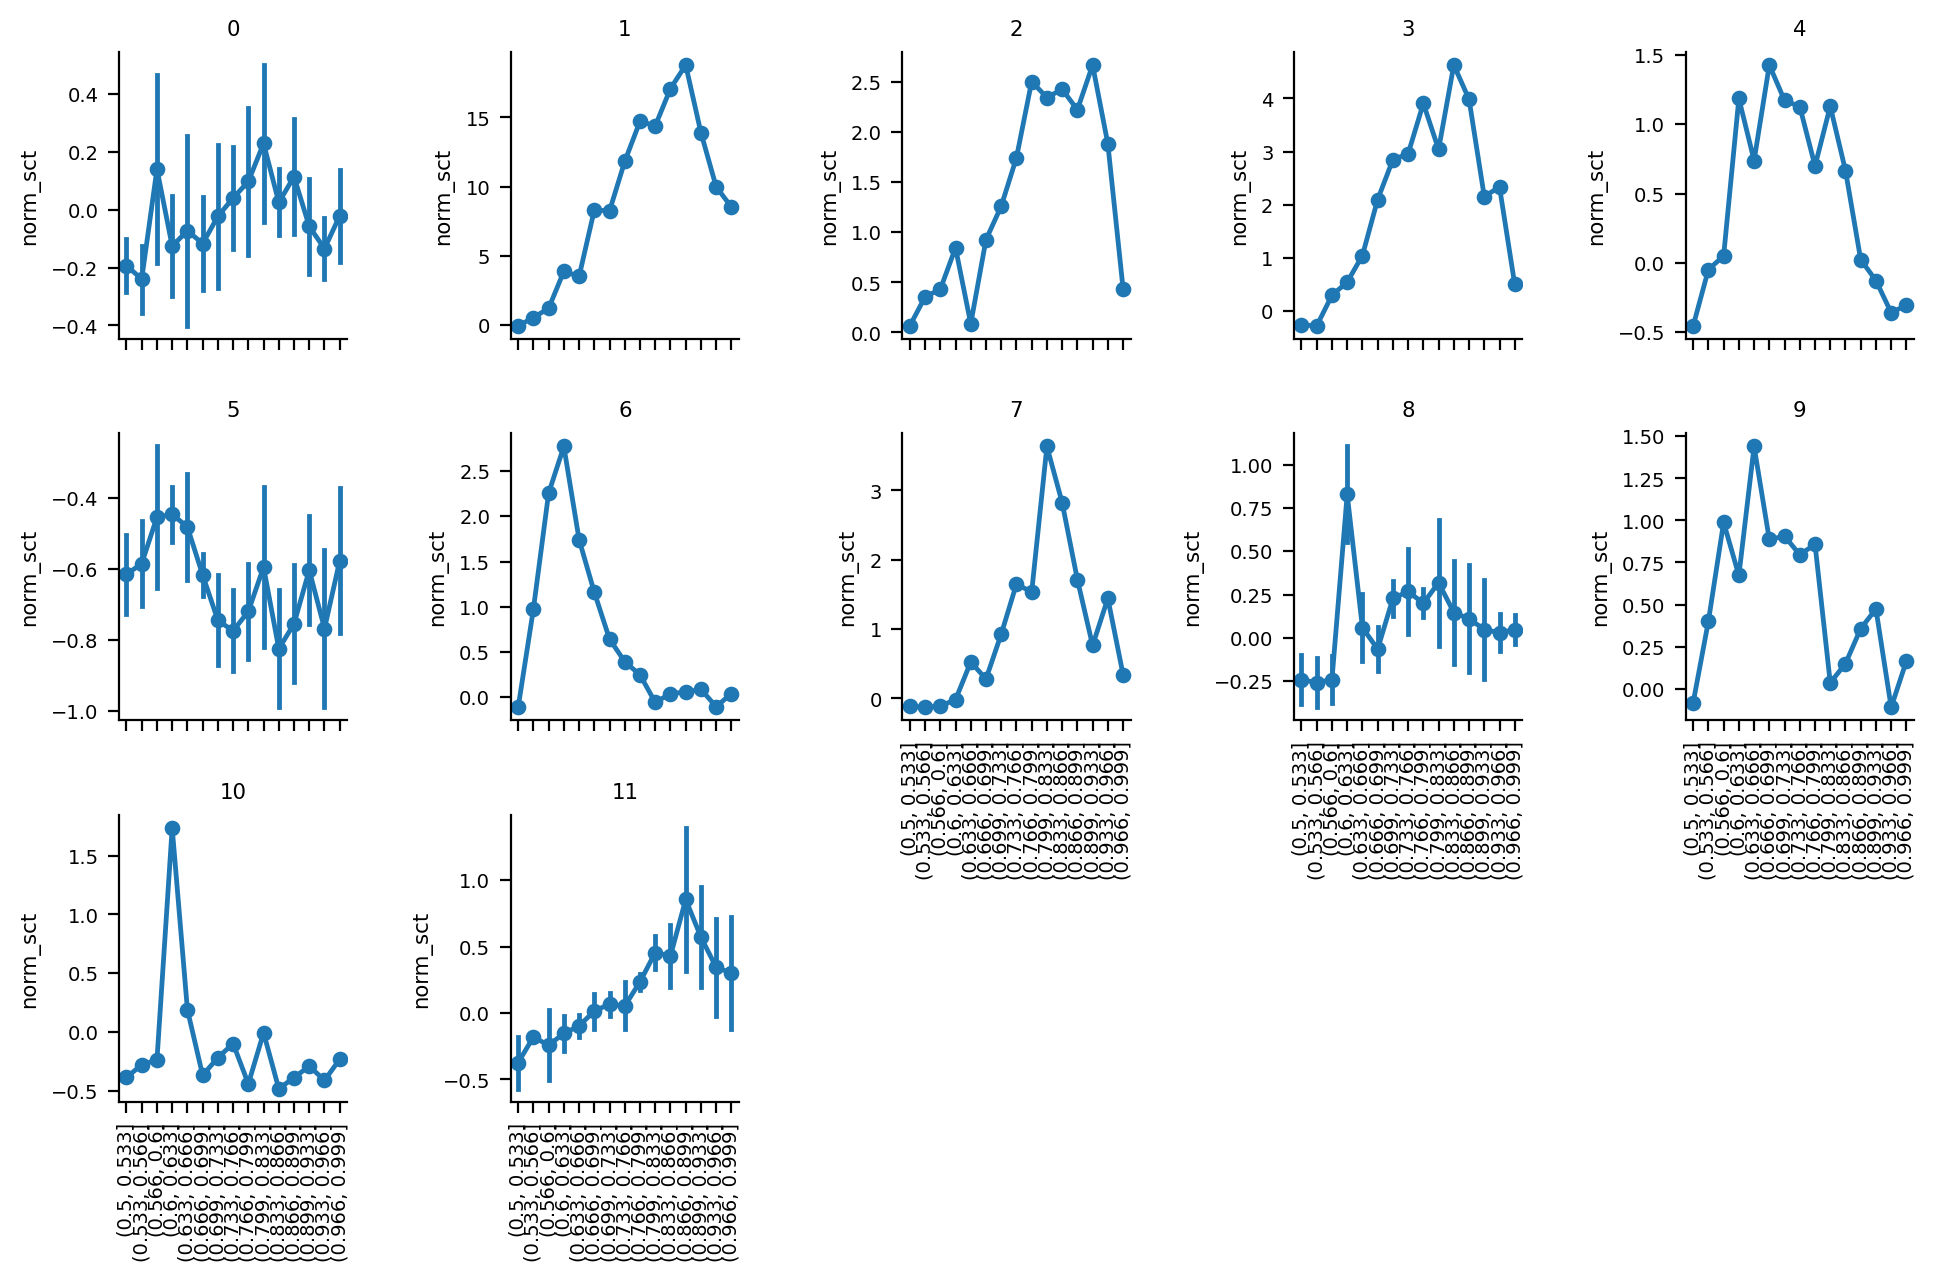

In [20]:
g = sns.FacetGrid(plot_df,
                  col="membership", height=2, col_wrap=5, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=ptime_bins, 
      errorbar='sd')
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('norm_sct')
    # ax.axvline(6.5, color='grey', linestyle='dashed')
    # ax.axvline(12, color='grey', linestyle='dashed')
    # ax.axvline(14.5, color='grey', linestyle='dashed')    
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

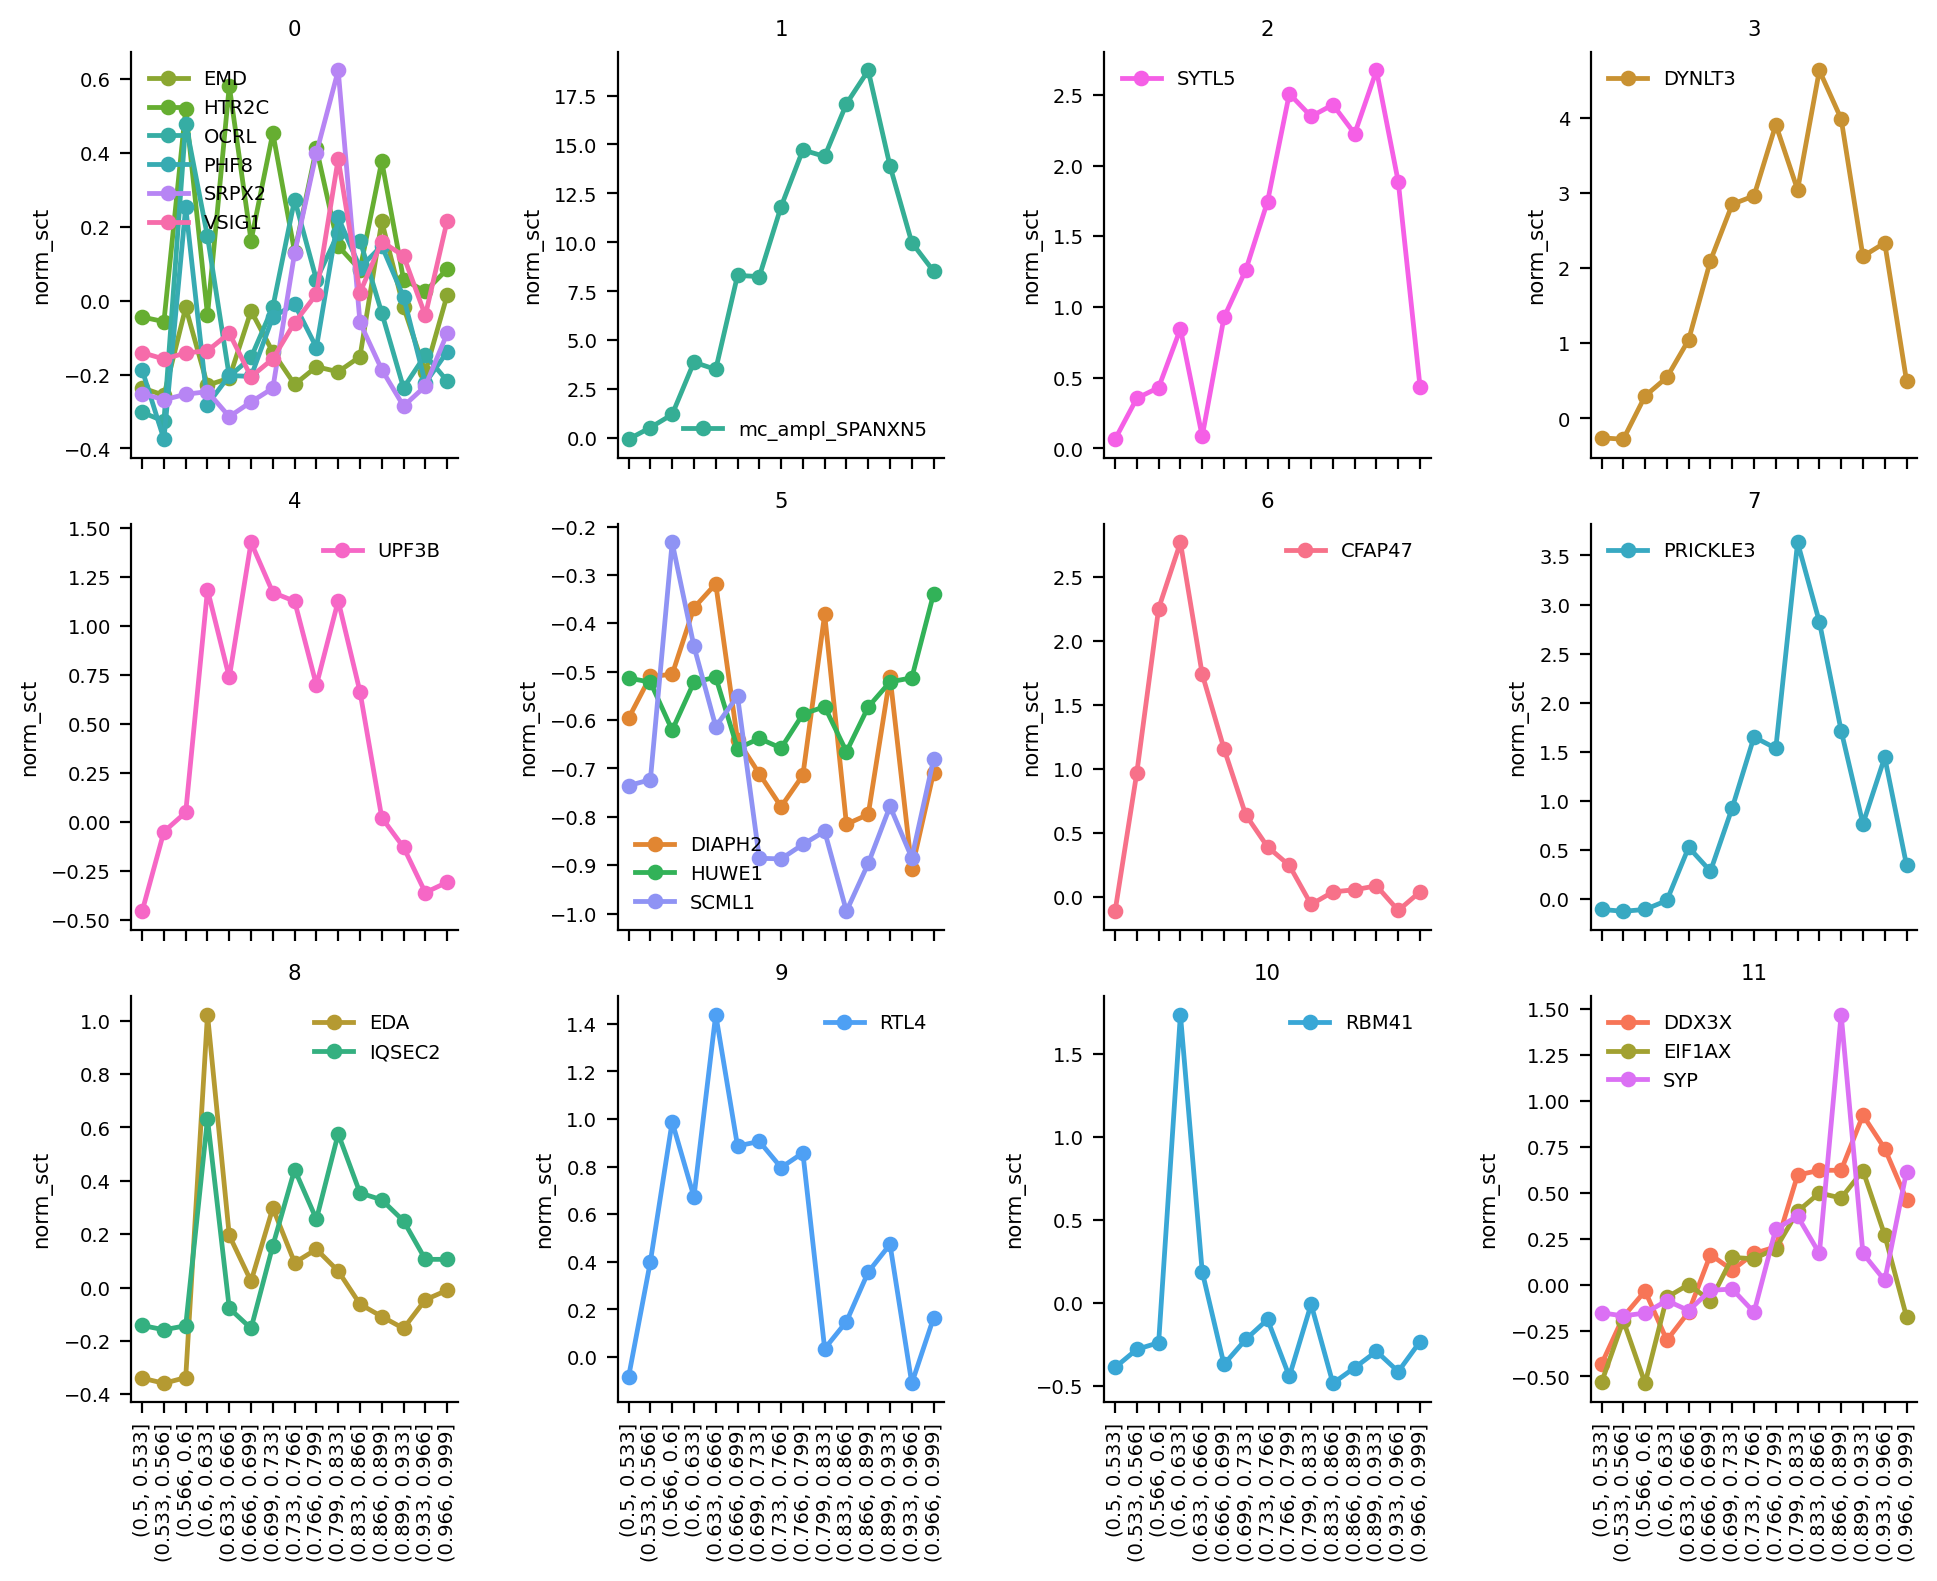

In [21]:
g = sns.FacetGrid(plot_df, 
                  col="membership", hue="gene", height=2.5, col_wrap=4, sharey=False)
g.map(sns.pointplot, 'ptime', 'expression', 
      order=ptime_bins, 
      errorbar=None, 
      # color='black'
     )

for ax in g.axes.flat:
    ax.legend(frameon=False)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_xlabel(None)
    ax.set_ylabel('norm_sct')
    # ax.axvline(6.5, color='grey', linestyle='dashed')
    # ax.axvline(12, color='grey', linestyle='dashed')
    # ax.axvline(14.5, color='grey', linestyle='dashed')
    plt.setp(ax.collections, sizes=[0], alpha=1) #for the markers
    plt.setp(ax.lines, alpha=1)       #for the lines    
    #plt.setp(ax.collections, )
g.set_titles(col_template="{col_name}", row_template="{row_name}") ;

In [22]:
gr = plot_df[['gene', 'membership']].drop_duplicates().sort_values(['membership', 'gene']).groupby('membership').gene


In [19]:
import geneinfo.information as gi

In [ ]:
time_bins = 100
chrom_size = 156040895
window_size = 100_000

# df = ep.adata[ep.adata.obs.SPECIES == "Human", ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
# df = ep.adata[ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
df = ep.adata.to_df(layer='norm_sct')
df['ptime'] = ep.adata.obs.Pseudotime_scaled // (1/time_bins)
df = df.groupby('ptime').mean()
df.columns.name = 'gene'
df = df.transpose()

genes = [x.replace('mc_ampl_', '') for x in df.index.values]
gene_coords = pd.DataFrame().from_records(gi.gene_labels(genes, assembly='hg38'), columns=['chrom', 'pos', 'gene'])
_df = df.merge(gene_coords, on='gene', how='left')
_df.drop(columns=['chrom'], inplace=True)
_df['window'] = _df.pos // window_size * window_size + window_size/2
_df = _df.set_index('window')

# INCLUDE THIS TO SHOW MISSSING DATA
# full = pd.DataFrame(np.nan, index=np.arange(0, chrom_size, window_size) + window_size/2, columns=np.arange(time_bins).astype(float)) 
# full.index.name = 'window'
# _df, _ = _df.align(full, join='outer')

_df = _df.groupby(['window']).agg('mean', numeric_only=True).reset_index().drop(columns=['pos'])

plot_df = _df.set_index('window').transpose()
xticklabels = [x/1_000_000 if not i % 50 else '' for i, x in enumerate(plot_df.columns)]
yticklabels = [y if not y % 5 else '' for i, y in enumerate(plot_df.index)]

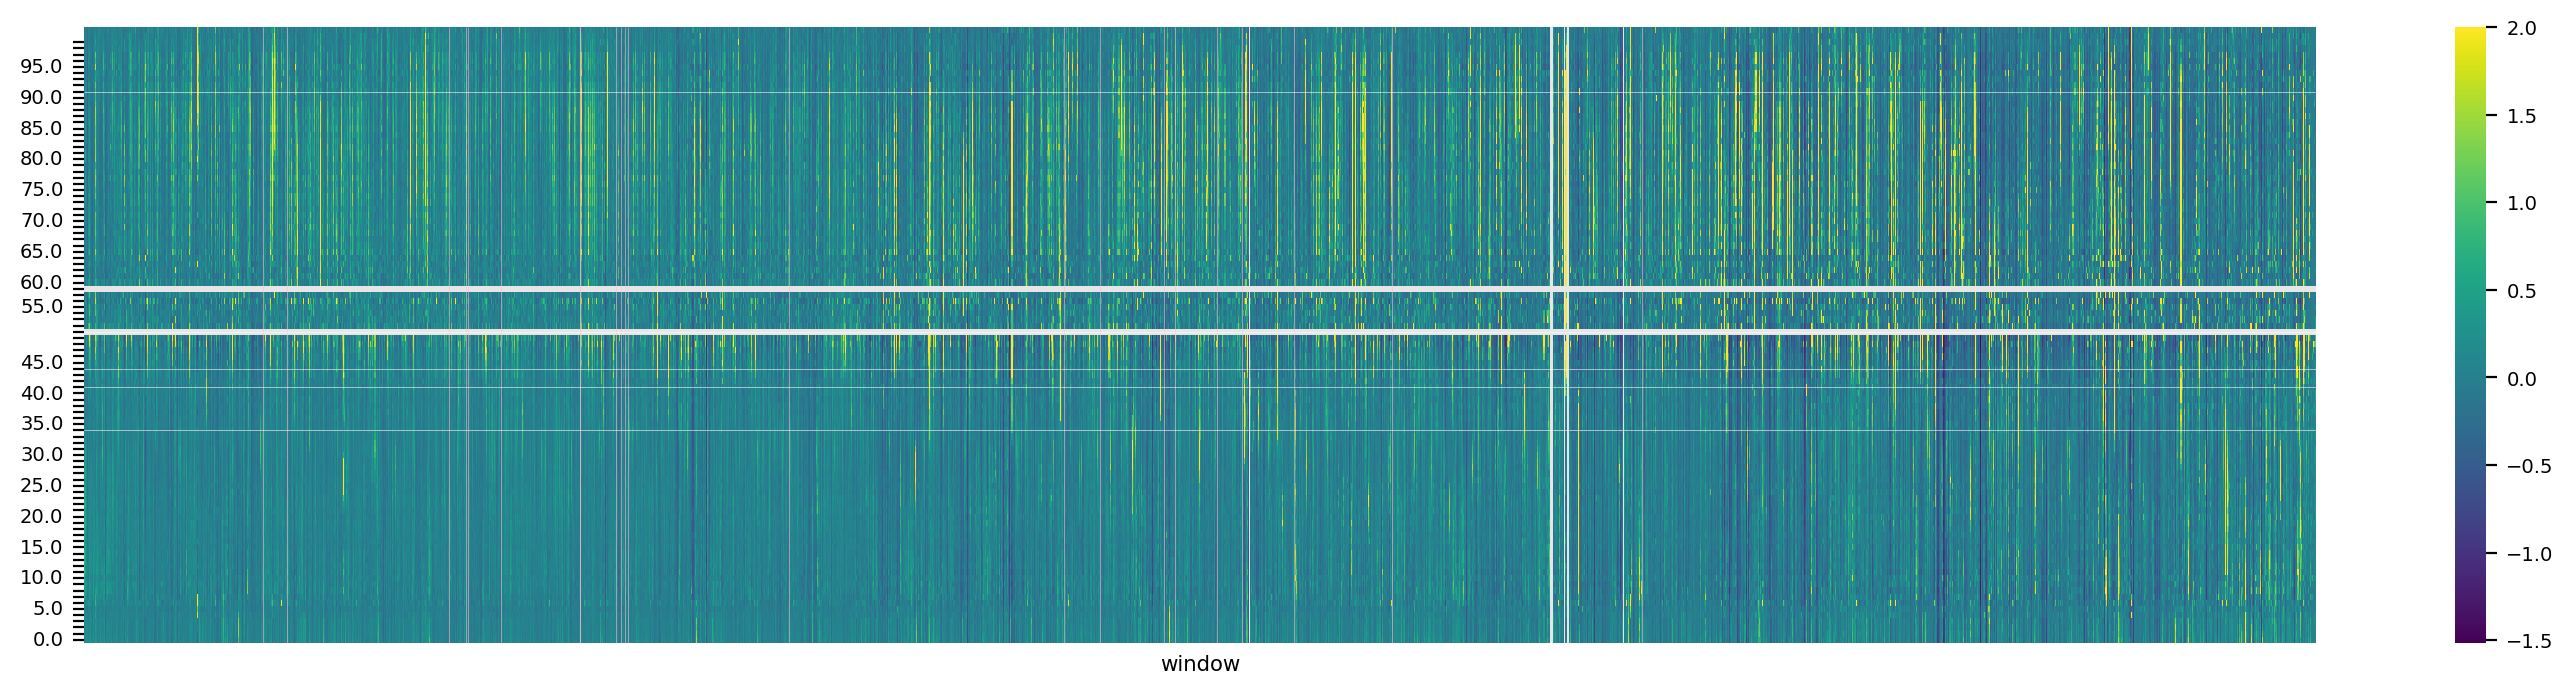

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.heatmap(plot_df, cmap='viridis', vmax=2, ax=ax, xticklabels=xticklabels, yticklabels=yticklabels)
ax.collections[0].cmap.set_bad('0.9')
ax.tick_params(axis='x', labelrotation=90)
# ax.set_xticks([x*1_000_000 for x in xticklabels if x])
ax.set_xticks([])
ax.tick_params(axis='y', labelrotation=0)
# ax.invert_yaxis()

ax.set_ylim(0, 100)

gene_set = 'cDEG'
# gene_set = 'nDEG'
coords = gi.gene_labels([x.replace('mc_ampl_', '') for x in sheet.get(gene_set)], 'hg38')
pos = [np.argmin(np.absolute(plot_df.columns.to_numpy() - x[1]))+0.5 for x in coords]
ax.vlines(pos, 0, 100, lw=0.2, color='pink');
lines = np.array([#0.04, 0.14, 0.25,
                  0.34, 0.41, 0.44, 0.5, 0.89])
pos = [np.argmin(np.absolute(plot_df.index.to_numpy() - x))+0.5 for x in lines*100]
ax.hlines(pos, 0, 155e6, lw=0.2, color='white');

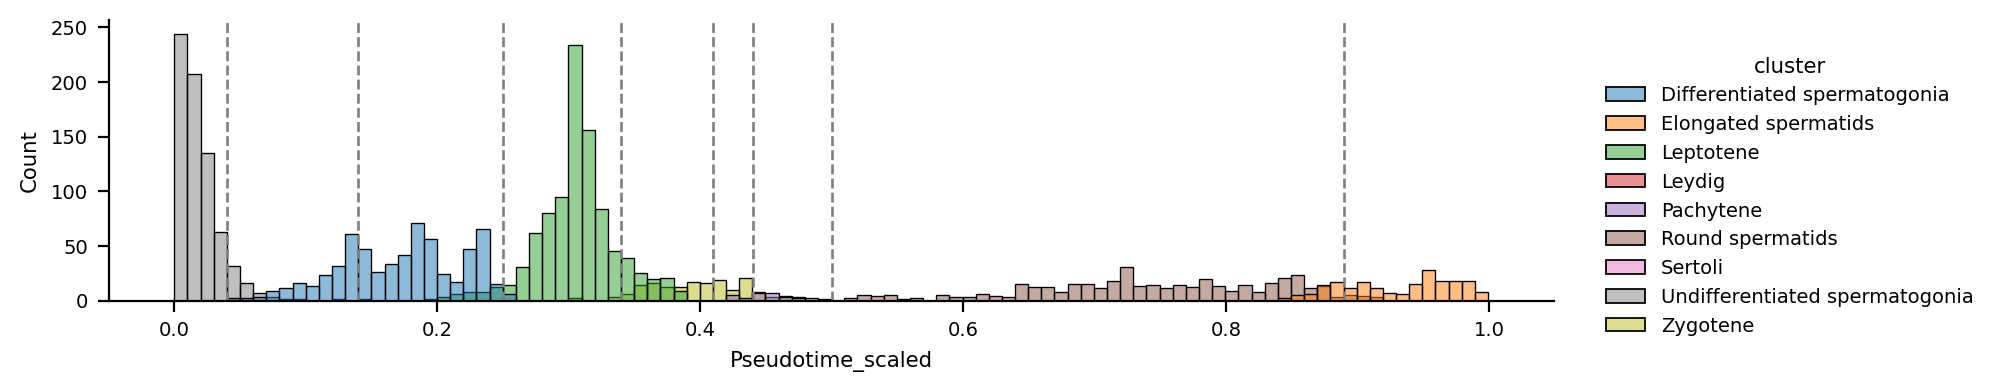

In [23]:
df = sc.get.obs_df(ep.adata, keys=['cluster', 'Pseudotime_scaled'])
sns.displot(df, x='Pseudotime_scaled', hue='cluster', bins=100, height=2, aspect=4) ;
lines = [0.04, 0.14, 0.25, 0.34, 0.41, 0.44, 0.5, 0.89]
[plt.axvline(x, color='grey', linestyle='dashed') for x in lines] ;

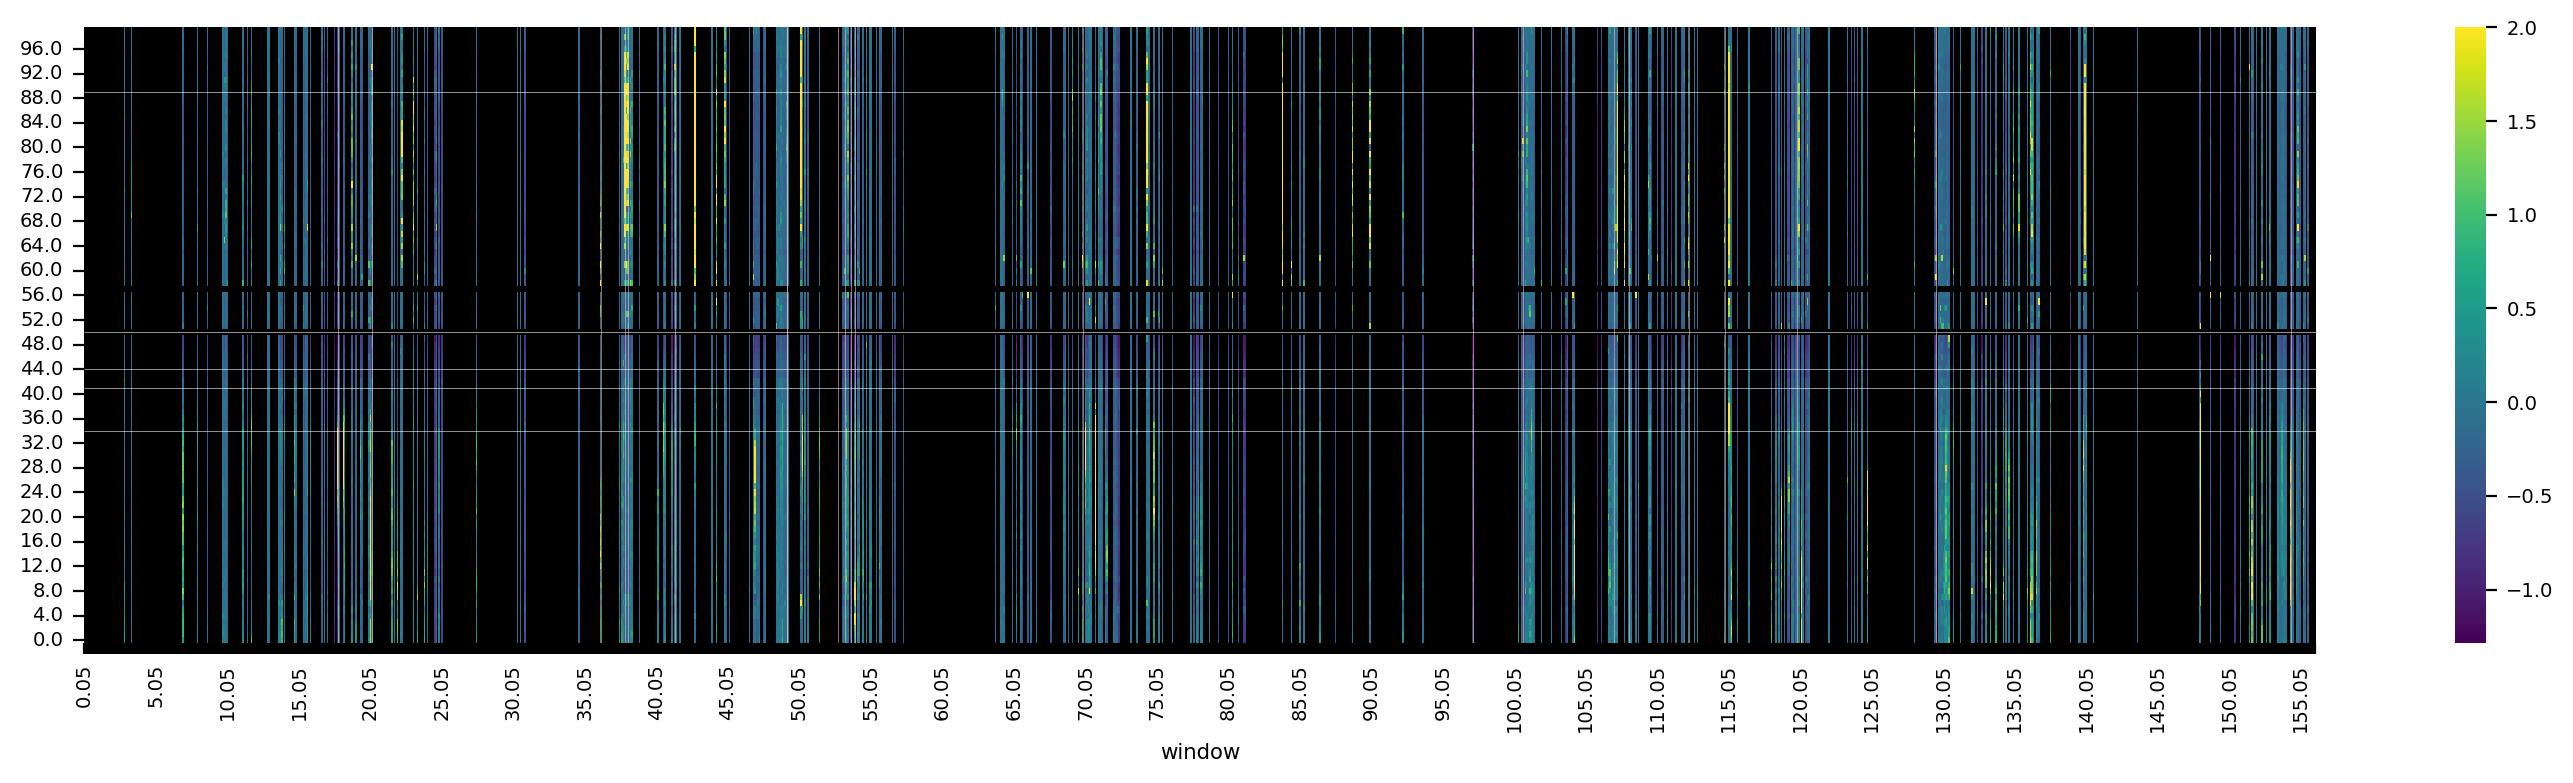

In [24]:
time_bins = 100
chrom_size = 156040895
window_size = 1_00_000

# df = ep.adata[ep.adata.obs.SPECIES == "Human", ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
df = ep.adata[:, ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
# df = ep.adata.to_df(layer='norm_sct')
df['ptime'] = ep.adata.obs.Pseudotime_scaled // (1/time_bins)
df = df.groupby('ptime').mean()
df.columns.name = 'gene'
df = df.transpose()

genes = [x.replace('mc_ampl_', '') for x in df.index.values]
gene_coords = pd.DataFrame().from_records(gi.gene_labels(genes, assembly='hg38'), columns=['chrom', 'pos', 'gene'])
_df = df.merge(gene_coords, on='gene', how='left')
_df.drop(columns=['chrom'], inplace=True)
_df['window'] = _df.pos // window_size * window_size + window_size/2
_df = _df.set_index('window')

full = pd.DataFrame(np.nan, index=np.arange(0, chrom_size, window_size) + window_size/2, columns=np.arange(time_bins).astype(float)) 
full.index.name = 'window'
_df, _ = _df.align(full, join='outer')

_df = _df.groupby(['window']).agg('mean', numeric_only=True).reset_index().drop(columns=['pos'])

plot_df = _df.set_index('window').transpose()
xticklabels = [x/1_000_000 if not i % 50 else '' for i, x in enumerate(plot_df.columns)]
# ax.set_xticks([x*1_000_000 for x in xticklabels if x])
ax.set_xticks([])
# ax.xaxis.set_ticks_position('none') 

fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.heatmap(plot_df, cmap='viridis', vmax=2, ax=ax, xticklabels=xticklabels)
ax.collections[0].cmap.set_bad('0.0')
ax.tick_params(axis='x', labelrotation=90)
ax.invert_yaxis()

ax.set_ylim(0, 100)
# plt.axis('off')

gene_set = 'cDEG'
# gene_set = 'nDEG'
coords = gi.gene_labels([x.replace('mc_ampl_', '') for x in sheet.get(gene_set)], 'hg38')
pos = [np.argmin(np.absolute(plot_df.columns.to_numpy() - x[1]))+0.5 for x in coords]
ax.vlines(pos, 0, 100, lw=0.2, color='pink');
lines = np.array([#0.04, 0.14, 0.25,
                  0.34, 0.41, 0.44, 0.5, 0.89])
pos = [np.argmin(np.absolute(plot_df.index.to_numpy() - x))+0.5 for x in lines*100]
ax.hlines(pos, 0, 155e6, lw=0.2, color='white');

                gene       0.0       1.0       2.0       3.0       4.0  \
0               GYG2  0.531088  0.548251  0.383405  0.593206  0.171225   
1              MXRA5  0.040007 -0.033946 -0.005972  0.041352 -0.020398   
2               PUDP  0.532423  0.933026  0.907878  0.947344  0.808792   
3             PNPLA4  0.277804  0.198306  0.120571  0.038749 -0.017309   
4              ANOS1 -0.216017 -0.083442  0.064402 -0.298135 -0.120803   
..               ...       ...       ...       ...       ...       ...   
547   mc_ampl_XAGE1A  5.640879  3.700162  4.087658  3.527444  1.495065   
548      mc_ampl_YY2  0.029689 -0.088738 -0.165932 -0.077066 -0.204246   
549  mc_ampl_ZCCHC12 -0.118818 -0.123454 -0.131296 -0.047427 -0.067901   
550   mc_ampl_ZNF711 -0.350870 -0.361259 -0.288144 -0.298586 -0.311432   
551     mc_ampl_ZXDB -0.025636 -0.066365 -0.082872 -0.007340 -0.083510   

          5.0       6.0       7.0       8.0  ...      91.0      92.0  \
0    0.259107  0.088315  0.376034  0.52

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_13467/3323322078.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos[-nr_windows:] = np.arange(0, 154_000_000, window_size)


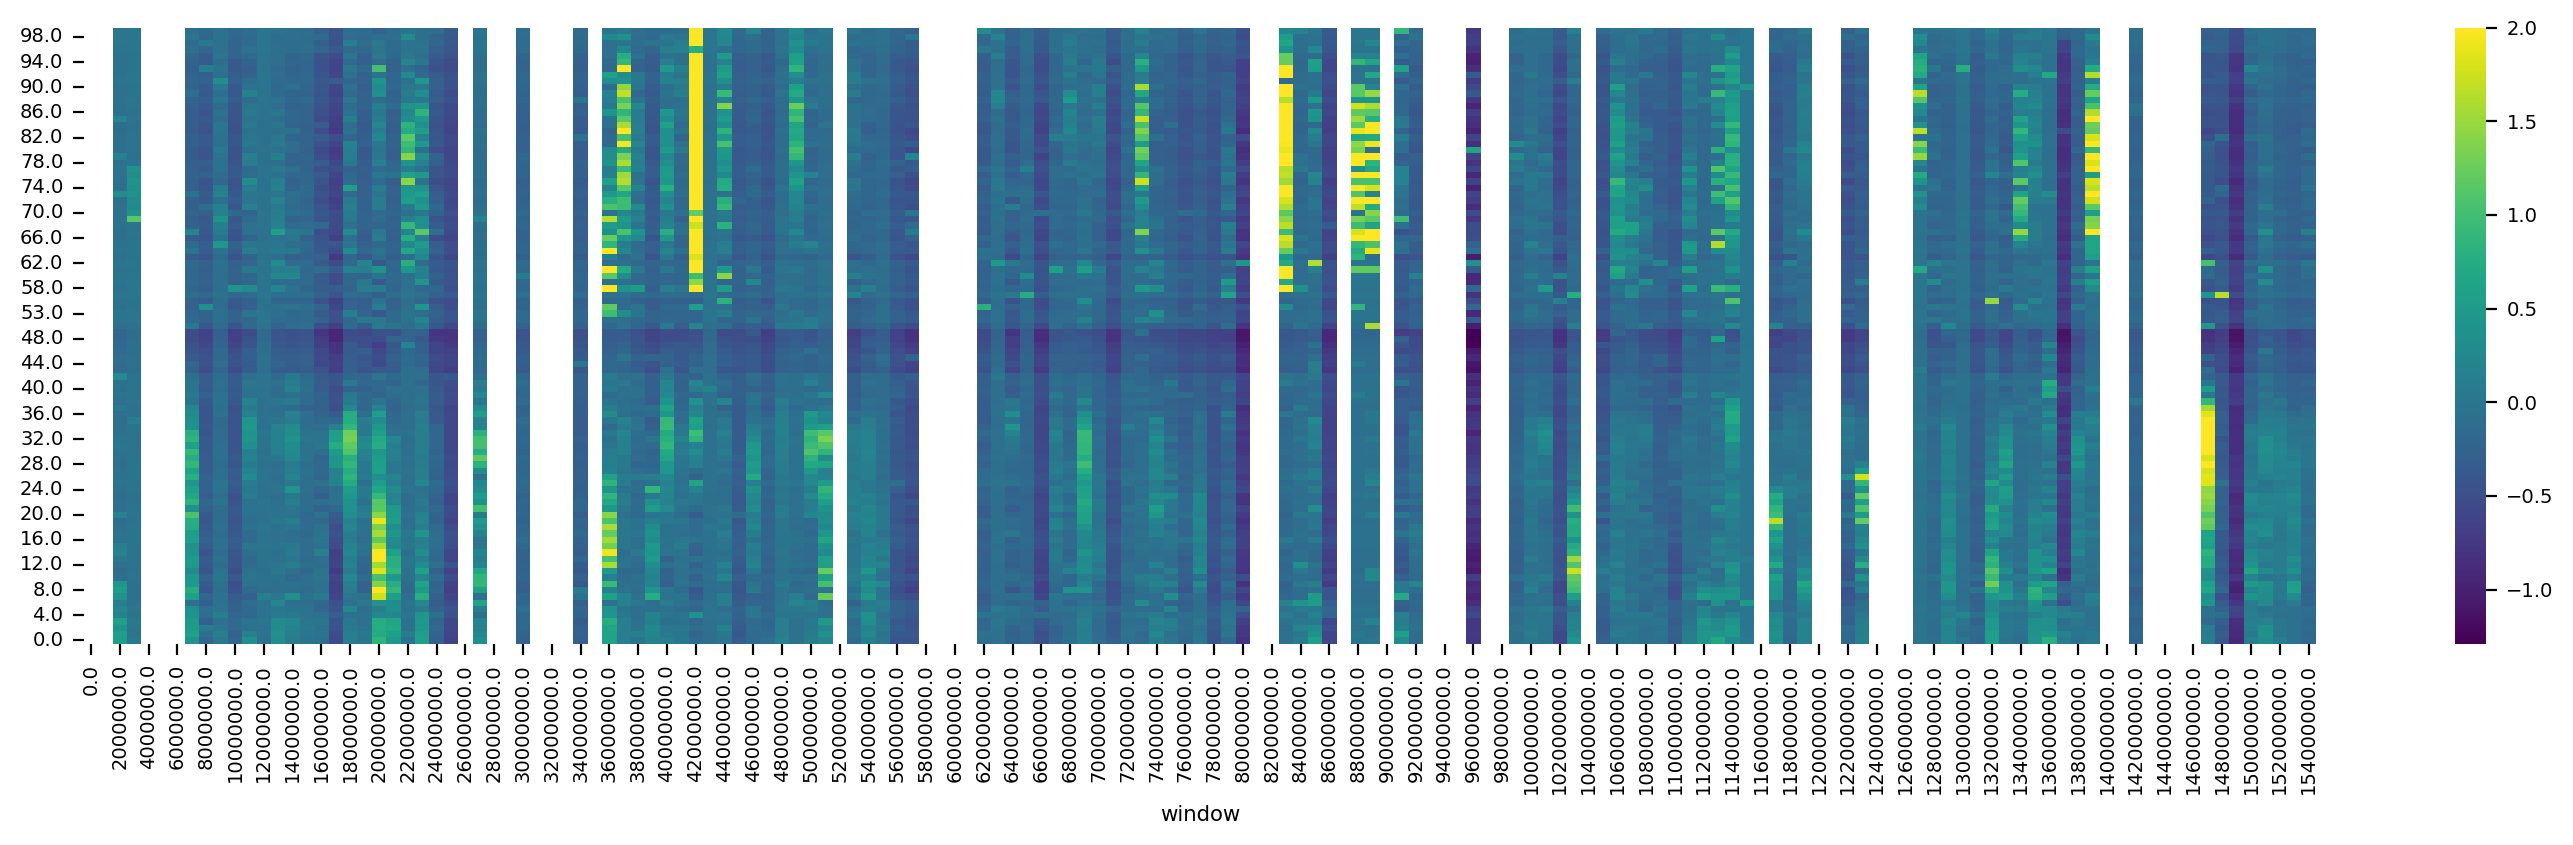

In [25]:
# df = ep.adata[ep.adata.obs.SPECIES == "Human", ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
# df = ep.adata[ep.adata.var.chromosome == 'X'].to_df(layer='norm_sct')
df = ep.adata.to_df(layer='norm_sct')
time_bins = 100
df['ptime'] = ep.adata.obs.Pseudotime_scaled // (1/time_bins)

# # _df = df.iloc[0:100, :].copy()
# # _df.iloc[:, :] = np.nan
# # _df['ptime'] = np.arange(0, 100)
# nr_windows = 154_000_000 // 10_000
# dummy = df.iloc[0:100, :].copy()
# dummy.iloc[:, :] = np.nan
# dummy_df_list = []
# for w in range(nr_windows):
#     _df = dummy.copy()
#     _df['ptime'] = np.arange(0, 100)
#     _df['window'] = w
#     dummy_df_list.append(_df)
# df = pd.concat([df, *dummy_df_list])


means_fine_df_all = df.groupby('ptime').mean()
means_fine_df_all.columns.name = 'gene'
means_fine_df_all = means_fine_df_all.transpose()


# only chrX
means_fine_df = means_fine_df_all#.loc[ep.adata.var.chromosome == 'X']
means_fine_df


genes = [x.replace('mc_ampl_', '') for x in means_fine_df.index.values]

# gene_coords = pd.DataFrame().from_records(gi.gene_coords(genes, assembly='hg19'), columns=['chrom', 'start', 'end', 'gene'])
gene_coords = pd.DataFrame().from_records(gi.gene_labels(genes, assembly='hg19'), columns=['chrom', 'pos', 'gene'])


# means_fine_df.merge(gene_coords, on='gene').set_index(['chrom', 'start', 'end', 'gene'])
_df = means_fine_df.merge(gene_coords, on='gene', how='left')#.set_index(['chrom', 'pos', 'gene'])


_df.drop(columns=['chrom'], inplace=True)

print(_df)

window_size = 1000_000
nr_windows = 154_000_000 // window_size
dummy = _df.iloc[0].copy()
dummy.iloc[:] = np.nan
_df = _df._append([dummy] * nr_windows, ignore_index=True)
pos = _df.pos
pos[-nr_windows:] = np.arange(0, 154_000_000, window_size)
_df['pos'] = pos


_df['window'] = _df.pos // window_size * window_size



# nr_windows = 154_000_000 // 10_000
# dummy = _df.iloc[0:100, :].copy()
# dummy.iloc[:, :] = np.nan
# dummy_df_list = []
# for w in range(nr_windows):
#     _dum = dummy.copy()
#     _dum['ptime'] = np.arange(0, 100)
#     _dum['window'] = w
#     dummy_df_list.append(_dum)
# _df = pd.concat([df, *dummy_df_list])


# nr_windows = 154_000_000 // 10_000
# dummy = df.iloc[0].copy()
# df._append([dummy] * nr_windows, ignore_index=True)
# print(df)
# df.loc[df.iloc[-nr_windows:].index, 'window'] = np.arange(0, 154_000_000, 10_000)

# l = []
# for w in np.arange(0, 154_000_000, 10_000):
#     dummy = _df.iloc[0].copy()
#     dummy['window'] = w
#     dummy
# df = pd.concat([df. pd])

# print(__df)
# __df['window'] = np.arange(0, 154_000_000, 10_000)
# _df = pd.concat([_df, __df])


_df = _df.groupby(['window']).agg('mean', numeric_only=True).reset_index().drop(columns=['pos'])
_df.head()


fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.heatmap(_df.set_index('window').transpose(), cmap='viridis', vmax=2, ax=ax)
ax.invert_yaxis()
#plt.xticks(list(range(0, 155, 15)), list(range(0, 155000000, 10000000)))

#ax.hlines(lines, color='white', linewidth=0.1, transform=ax.transAxes, xmin=0, xmax=150000000) ;

In [29]:
# df = ep.adata[ep.adata.obs.SPECIES == "Human"].to_df(layer='norm_sct')
df = ep.adata.to_df(layer='norm_sct')
cut = pd.cut(ep.adata.obs.Pseudotime_scaled, include_lowest=True, bins=100)

In [30]:
df['ptime'] = cut
ptime_bins = df['ptime'].unique().sort_values()
ptime_bins = ptime_bins[~ptime_bins.isnull()]
means_fine_df_all = df.groupby('ptime').mean()
means_fine_df_all.columns.name = 'gene'
means_fine_df_all = means_fine_df_all.transpose()
means_fine_df_all = means_fine_df_all[ptime_bins]

# only chrX
means_fine_df = means_fine_df_all.loc[ep.adata.var.chromosome == 'X']
#means_fine_df

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_98313/1073019559.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means_fine_df_all = df.groupby('ptime').mean()


In [31]:
genes = [x.replace('mc_ampl_', '') for x in means_fine_df.index.values]

# gene_coords = pd.DataFrame().from_records(gi.gene_coords(genes, assembly='hg19'), columns=['chrom', 'start', 'end', 'gene'])
gene_coords = pd.DataFrame().from_records(gi.gene_labels(genes, assembly='hg19'), columns=['chrom', 'pos', 'gene'])

In [32]:
# # means_fine_df.merge(gene_coords, on='gene').set_index(['chrom', 'start', 'end', 'gene'])
# _df = means_fine_df.merge(gene_coords, on='gene')#.set_index(['chrom', 'pos', 'gene'])
# _df['window'] = _df.pos // 10_000
# _df = _df.groupby(['chrom', 'window']).agg('mean', numeric_only=True).reset_index().drop(columns=['chrom', 'pos'])
# # _df = _df.reset_index()#.drop(columns=['chrom', 'pos'])
# _df.head()

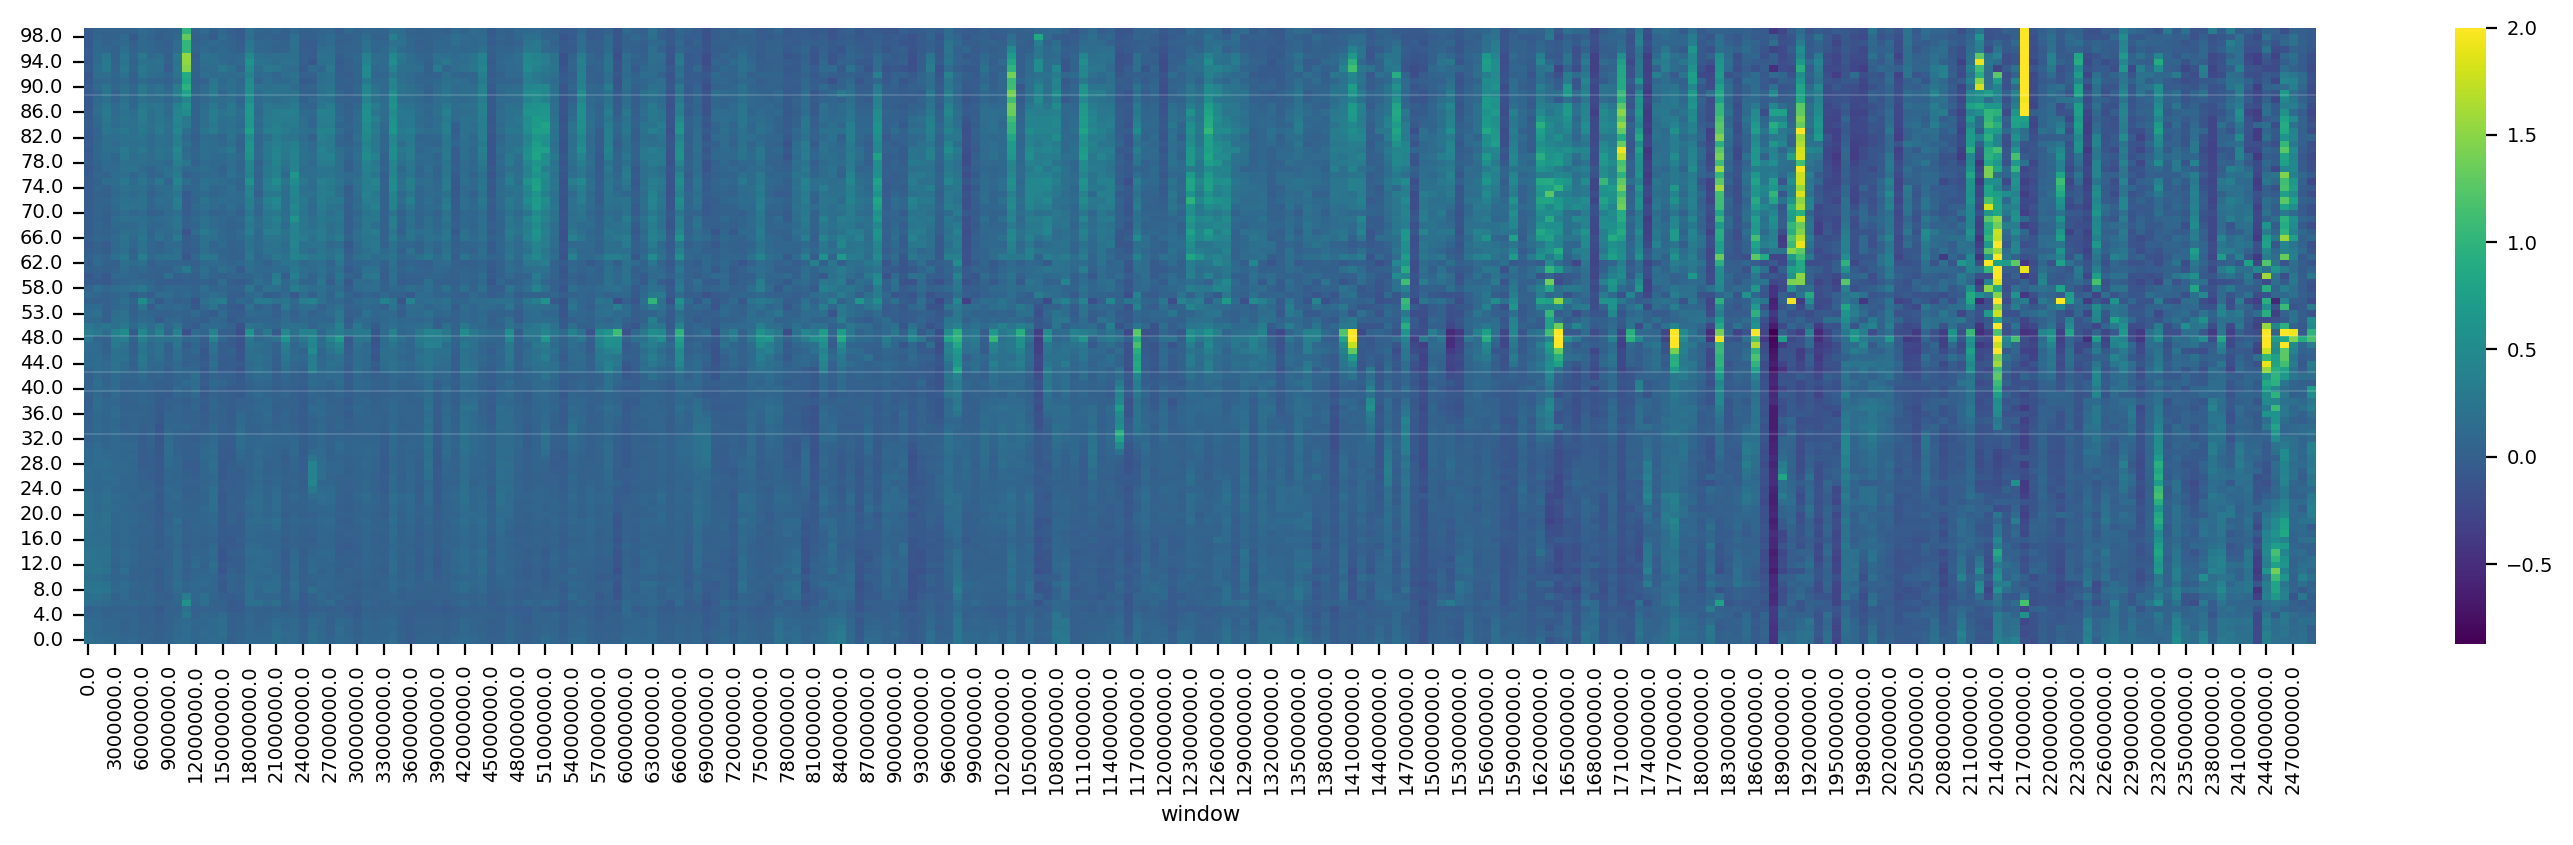

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 4))
sns.heatmap(_df.set_index('window').transpose(), cmap='viridis', vmax=2, ax=ax)
ax.invert_yaxis()
#plt.xticks(list(range(0, 155, 15)), list(range(0, 155000000, 10000000)))
ax.hlines(lines, color='white', linewidth=0.1, transform=ax.transAxes, xmin=0, xmax=150000000) ;

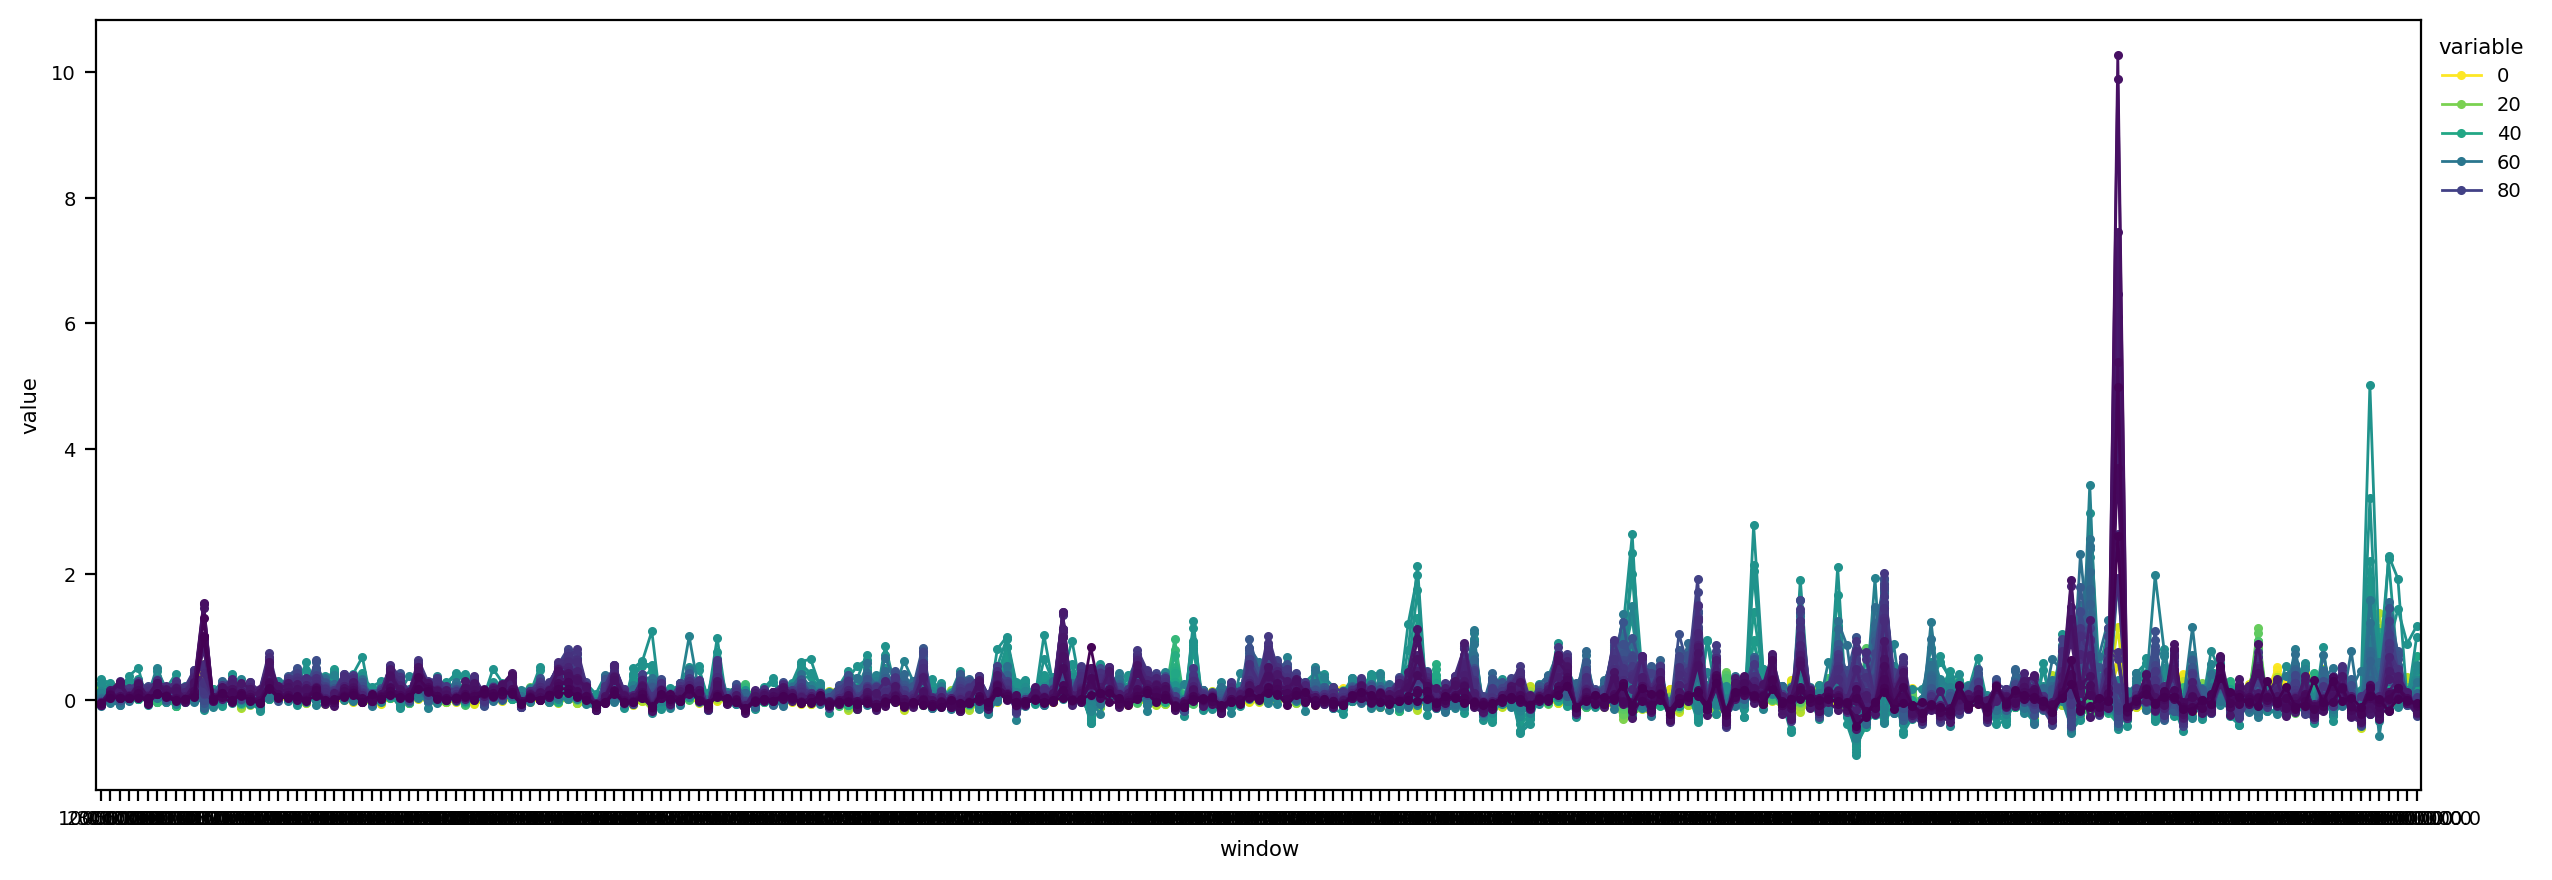

In [34]:
plot_df = _df.melt(id_vars=['window'])
plot_df.head()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
g = sns.pointplot(plot_df, x='window', y='value', hue='variable', errorbar=None, ax=ax, linewidth=1, palette='viridis_r')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), frameon=False)

In [35]:
g = sns.FacetGrid(plot_df, row="variable", hue="value", height=1.5, sharey=True, aspect=10)
g.map(sns.pointplot, 'window', 'value', 
      # order=plot_df.unique.sort_values(), 
      errorbar=None, 
      # color='black'
     )

/Users/kmt/cDEGexploration/.pixi/envs/default/lib/python3.12/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)

KeyboardInterrupt



Error in callback <function _draw_all_if_interactive at 0x19a4cb100> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x19ed24fe0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt

